# Q Annealing Pulser

In [1]:
import numpy as np
import json

import matplotlib.pylab as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm
import networkx as nx
from collections import defaultdict

from pulser import Pulse, Sequence, Register
from pulser.waveforms import CompositeWaveform, ConstantWaveform, RampWaveform, InterpolatedWaveform
from pulser.devices import AnalogDevice, DigitalAnalogDevice

from pulser_simulation import SimConfig, QutipEmulator

from pulser.json.abstract_repr.deserializer import deserialize_device

from pasqal_cloud import SDK

/home/andrea24/micromamba/envs/pasqal-cloud/lib/python3.13/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
class NumpyEncoder(json.JSONEncoder):
    """ Custom encoder for numpy data types """
    def default(self, obj):
        if isinstance(obj, ( np.int64)):
            return int(obj)      
        return json.JSONEncoder.default(self, obj)

In [3]:
file1 = open('./project_id.txt', 'r')
file2 = open('./username.txt','r')
file3 = open('./pass.txt', 'r')

project_id = file1.read()
username = file2.read()
password = file3.read()
file1.close()
file2.close()
file3.close()

# Initialize the cloud client
sdk = SDK(username=username, project_id=project_id,password=password)

specs = sdk.get_device_specs_dict()
device = deserialize_device(specs["FRESNEL"])

In [4]:
device_emu = AnalogDevice

In [5]:
def cost_function(x, G):
    obj = 0
    for i, j in G.edges():
        if x[i] + x[j] == "11":
            obj += 2
    return - x.count("1") + obj

In [6]:
backends = {}
backends["pasqal_fresnel"] = device
backends["pulser_emulator"] = device_emu
backends["pulser_emulator_noisy"] = device_emu

In [53]:
params = {'Omega': {'t 1000' : 3.25080887,'t 2000' : 2.5652778259641584, 't 4000' : 2.5459517701356527}, 
          'Delta_i': {'t 1000' : -2.21394214,'t 2000' : -3.054642235787642, 't 4000' : -6.175726575815153}, 
          'Delta_f': {'t 1000' : 3.10496435,'t 2000' : 6.044076733967179, 't 4000' : 6.186741234222494}}

with open(f"./Data/opt_schedule_QAA.json", "w") as file:
        json.dump(params,file,cls=NumpyEncoder)

In [54]:
# Prepare Pulse (Independent of the problem size)

method = "QAA"

t_rise = 300
t_sweep = 400
t_fall = 300

t_tot = t_rise+t_sweep+t_fall
t_delay = 0

with open(f"./Data/opt_schedule_{method}.json", "r") as file:
    schedule = json.load(file)

Omega_s = schedule['Omega'][f't {t_tot}']
Delta_i = schedule['Delta_i'][f't {t_tot}']
Delta_f = schedule['Delta_f'][f't {t_tot}']

rise = Pulse.ConstantDetuning(
    RampWaveform(t_rise, 0.0, Omega_s), Delta_i, 0.0
)
sweep = Pulse.ConstantAmplitude(
    Omega_s, RampWaveform(t_sweep, Delta_i, Delta_f), 0.0
)
fall = Pulse.ConstantDetuning(
    RampWaveform(t_fall, Omega_s, 0.0), Delta_f, 0.0
)

In [59]:
# Prepare Register

nq =  13# can do until 51
with open(f"./Data/Problems/{nq}.json", "r") as file:
    problem = json.load(file)

G = nx.Graph()
G.add_nodes_from(range(nq))
G.add_edges_from(problem["edges"])
problem.keys()
a = 5.
grid_side = problem["grid_side"]
pos = problem["pos"]
numx,numy = [grid_side,grid_side]
x_shift = a * (numx - 1) / 2
y_shift = a * (numy - 1) / 2
pos_dict = {}
for i, pos_i in enumerate(pos):
    pos_dict[f"q{i}"] = [round(pos_i[0] * a - x_shift,8), round(pos_i[1] * a - y_shift,8)]

register = Register(pos_dict)

# register.draw(with_labels=True,
#           blockade_radius=2**(3/4)*a,
#           draw_graph=True,
#           draw_half_radius=True,
#           qubit_colors={},
#           fig_name=None,#f"./../../Plots/reg2.png",
#           kwargs_savefig={},
#           custom_ax=None,
#           show=True)

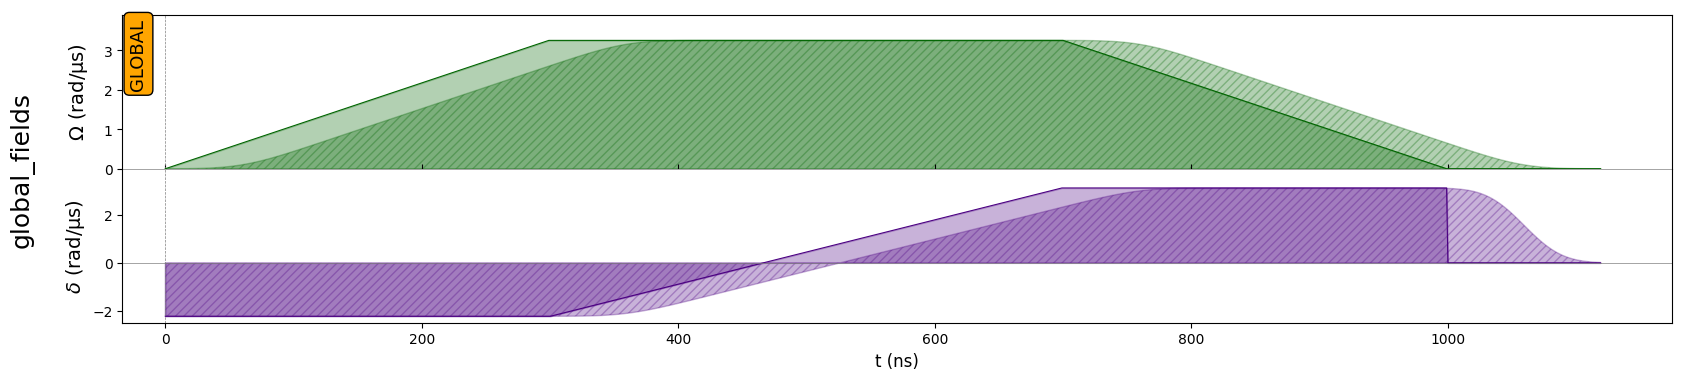

In [60]:
# Run experiment

shots = 500
result = {}
backend_name = ["pulser_emulator", "pulser_emulator_noisy", "pasqal_fresnel"][0]

if backend_name == "pasqal_fresnel":
    register = register.with_automatic_layout(backends[backend_name])

sequence = Sequence(register, backends[backend_name])
sequence.declare_channel('global_fields', 'rydberg_global')
sequence.delay(t_delay,'global_fields')
sequence.add(rise, "global_fields")
sequence.add(sweep, "global_fields")
sequence.add(fall, "global_fields")
sequence.draw()

if backend_name == "pulser_emulator":
    config = SimConfig()
if backend_name == "pulser_emulator_noisy":
    config = SimConfig(noise=("SPAM"), eta=0.02,epsilon=0.01,epsilon_prime=0.08,runs=30, samples_per_run=5)

if backend_name in ["pulser_emulator", "pulser_emulator_noisy"]:
    emu = QutipEmulator.from_sequence(sequence, sampling_rate = 0.05, evaluation_times=0.1,config=config).run()
    #job = QutipBackend(sequence, config = config).run()
    result["samples"] = emu.sample_final_state(N_samples=shots)
    with open(f"./Data/{backend_name}/{method}/t{t_tot}/{nq}.json", "w") as file:
        json.dump(result,file,cls=NumpyEncoder)
if backend_name == "pasqal_fresnel":
    serialized_sequence = sequence.to_abstract_repr()
    job = {"job_ID":f"nq{nq}","runs": shots}
    batch = sdk.create_batch(serialized_sequence, [job]#, emulator=EmulatorType.EMU_FREE
                            )

In [62]:
# Postprocessing

nq = 13
backend_name = ["pulser_emulator", "pulser_emulator_noisy", "pasqal_fresnel"][0]
with open(f"./Data/{backend_name}/{method}/t{t_tot}/{nq}.json", "r") as file:
    result = json.load(file)
if backend_name == "pasqal_fresnel":
    batch_id = list(result.keys())[0]
    result = result[batch_id]
    result['samples'] = result.pop('counter')
    

with open(f"./Data/problems/{nq}.json", "r") as file:
    problem = json.load(file)
G = nx.Graph()
G.add_nodes_from(range(nq))
G.add_edges_from(problem["edges"])

cost_evals = defaultdict(int)
for k, v in result["samples"].items():
    cost = cost_function(k, G)
    cost_evals[cost] += v
result["cost"] = cost_evals 
result["min_cost"] = cost_function(problem["sol"], G)

with open(f"./Data/{backend_name}/{nq}.json", "w") as file:
    json.dump(result, file)

In [63]:
min_cost = result['min_cost']
prob_succ = result['cost'][min_cost]/shots
print(prob_succ)

0.434


In [18]:
sum(result['samples'].values())

500